**Chapter_2e**  
**ATMOS 6040: Environmental Statistics**  
**Alex Weech **

Download this notebook and all images and data by downloading the ZIP file from GitHub, or use the git command:

    git clone https://github.com/weech/ATMOS_5040_2019.git
    
> Note: Windows users will have to install [git for Windows](https://gitforwindows.org/) and execute the git command from the PowerShell.

# Using Julia modules
`DelimitedFiles` is a _standard library_ package that handles csv/tsv formats

`Statistics` is a _standard library_ package with some basic statistical functions

`Dates` is a _standard library_ package with Date and Time types and functions

`StatsBase` is a _3rd party package_ with fancier statistical functions

`DataFrames` provides R-like dataframe capabilities

`CSV` can read csv files of heterogeneous types

`PyPlot` is a _binding_ of Python's matplotlib

In [1]:
using DelimitedFiles
using Statistics
using Dates

using StatsBase
using CSV
using PyPlot
using DataFrames

# Chapter 2e

get time series of wind speed and direction from WBB for June 2018 in csv format
documentation on how that was done from Synoptic api services
http://synopticdata.com
http://api.synopticlabs.org/v2/stations/timeseries?stid=wbb&output=csv&obtimezone=local&start=201806010600&end=201807010559&vars=wind_speed,wind_direction,wind_gust&obtimezone=local&timeformat=%y%m%d%H%M&token=tk2019jan0216yZVw1gWKP6oIdgvChuT
requires an active token to run the above
returns a csv file with a header and text line that have been removed
4 columns: date(YYMMDDHHMM), wind speed (m/s) direction, wind gust(m/s)

In [2]:
#need to parse the date string
fmt = DateFormat("yymmddHHMM")
#there are times with no actual values (direction blank and wind speed and gust 0)
#those will get changed to missing by the CSV.read function
headers = ["Date", "Speed", "Direction", "Gust"]
dtypes = Dict("Date"=>DateTime)
millenia = Year(2000) # Because it's given as a 2-digit date
df = CSV.read("../data/wbb_wind_0618.csv", header=headers, dateformat=fmt, types=dtypes)
df.Date = df.Date .+ millenia;

In [3]:
#some basic info + output precentiles
basic_vals = describe(df)
println(basic_vals)
#note that there are "missing" blank wind directions and those values have 0 wind speed and gust
#so the counts of direction are lower than for speed. it is critical to remove those rows
#remove rows with a missing in any column
dropmissing!(df, disallowmissing=true)
basic_vals = describe(df)
println(basic_vals)
#now the number of rows is the same

4×8 DataFrame
│ Row │ variable  │ mean    │ min                 │ median │ max                 │ nunique │ nmissing │ eltype   │
│     │ Symbol    │ Union…  │ Any                 │ Union… │ Any                 │ Union…  │ Union…   │ DataType │
├─────┼───────────┼─────────┼─────────────────────┼────────┼─────────────────────┼─────────┼──────────┼──────────┤
│ 1   │ Date      │         │ 2018-06-01T00:00:00 │        │ 2018-06-30T23:59:00 │ 43149   │          │ DateTime │
│ 2   │ Speed     │ 3.04063 │ 0.0                 │ 2.75   │ 14.34               │         │ 9        │ Float64  │
│ 3   │ Direction │ 179.597 │ 0.01                │ 181.4  │ 360.0               │         │ 472      │ Float64  │
│ 4   │ Gust      │ 4.21242 │ 0.0                 │ 3.72   │ 19.3                │         │ 9        │ Float64  │
4×8 DataFrame
│ Row │ variable  │ mean    │ min                 │ median │ max                 │ nunique │ nmissing │ eltype   │
│     │ Symbol    │ Union…  │ Any                 │ 

# Figure 2.12 Statistics on Wind Speed and Direction


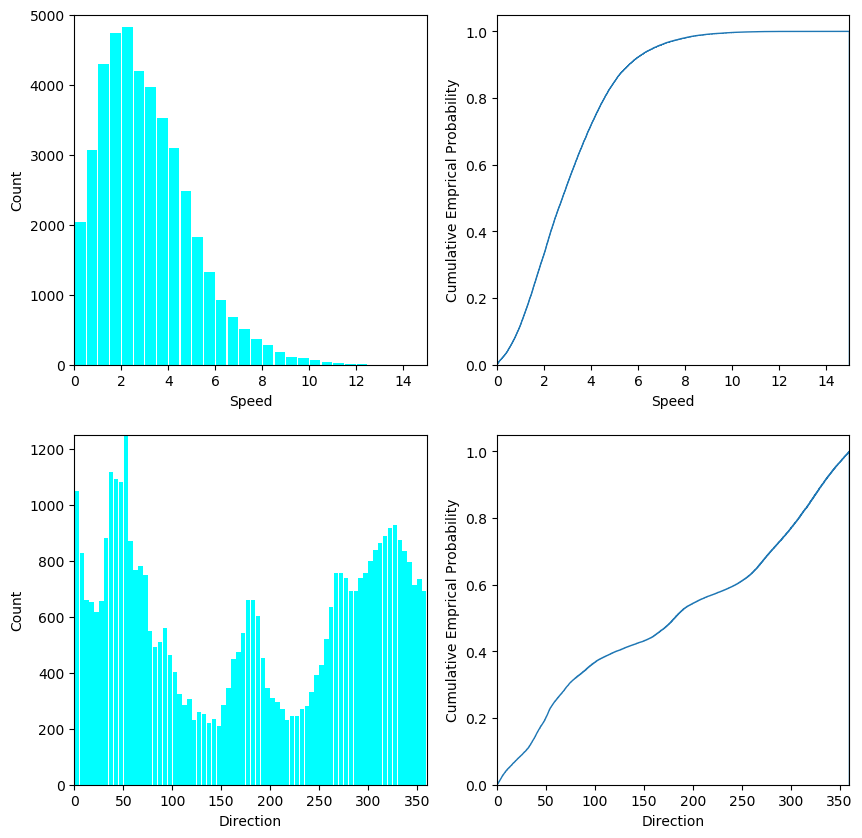

42677


In [4]:
fig, ax = subplots(2, 2, figsize=(10, 10))
x1 = collect(0.0:0.5:15.0)

ax1 = ax[1, 1]
ax1[:hist](df.Speed, x1, range=(0, 15), color="cyan", rwidth=0.9)
ax1[:set](xlim=(0, 15), ylim=(0, 5000))
ax1[:set](xlabel="Speed", ylabel="Count")

x2 = collect(0:5:360)
ax2 = ax[2, 1]
ax2[:hist](df.Direction, x2, range=(0, 360), color="cyan", rwidth=0.9)
ax2[:set](xlim=(0, 360),ylim=(0, 1250))
ax2[:set](xlabel="Direction", ylabel="Count")


#get total number of values
shape = size(df)
n_bins = shape[1]
println(n_bins)
ax3 = ax[1, 2]
ax3[:hist](df.Speed, n_bins, density="True", histtype="step", 
                              cumulative=true, label="Empirical", range=(0, 15))

ax3[:set](xlabel="Speed",ylabel="Cumulative Emprical Probability")
ax3[:set](xlim=(0, 15))

ax4 = ax[2, 2]
ax4[:hist](df.Direction, n_bins, density="True", histtype="step",
                              cumulative=true, label="Empirical", range=(0, 360))

ax4[:set](xlabel="Direction", ylabel="Cumulative Emprical Probability")
ax4[:set](xlim=(0, 360))
savefig("figure_2.12_2019_julia.png")

In [5]:
#convert spd,dir to u,v. Julia- 0 angle is relative to x axis and then counterclockwise
pid = pi / 180.
u = df.Speed .* sin.(pid .* (df.Direction .- 180))
v = df.Speed .* cos.(pid .*(df.Direction .- 180))
#add to dataframe the zonal and meridional values
df.u = u
df.v = v
#print(u)
#note that u and v computed for times when no missing data
basic_vals = describe(df)
println(basic_vals)

6×8 DataFrame
│ Row │ variable  │ mean      │ min                 │ median    │ max                 │ nunique │ nmissing │ eltype   │
│     │ Symbol    │ Union…    │ Any                 │ Union…    │ Any                 │ Union…  │ Nothing  │ DataType │
├─────┼───────────┼───────────┼─────────────────────┼───────────┼─────────────────────┼─────────┼──────────┼──────────┤
│ 1   │ Date      │           │ 2018-06-01T00:00:00 │           │ 2018-06-30T23:59:00 │ 42677   │          │ DateTime │
│ 2   │ Speed     │ 3.07362   │ 0.01                │ 2.78      │ 14.34               │         │          │ Float64  │
│ 3   │ Direction │ 179.597   │ 0.01                │ 181.4     │ 360.0               │         │          │ Float64  │
│ 4   │ Gust      │ 4.25805   │ 0.1                 │ 3.72      │ 19.3                │         │          │ Float64  │
│ 5   │ u         │ 0.0984685 │ -8.00797            │ 0.0137183 │ 10.3181             │         │          │ Float64  │
│ 6   │ v         │ -0.630

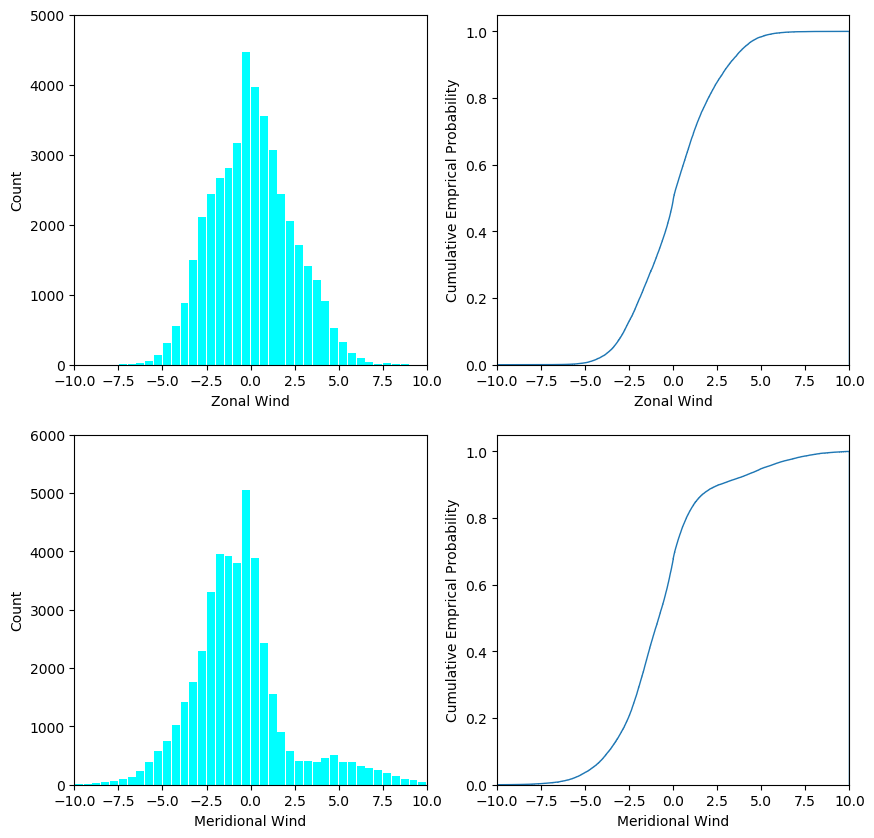

In [6]:
#plotting zonal and meridional wind statistics
fig, ax = subplots(2, 2, figsize=(10, 10))

x1 = collect(-10.0:0.5:10.0)
ax1 = ax[1, 1]
ax1[:hist](u, x1, range=(-10, 10), color="cyan", rwidth=0.9)
ax1[:set](xlim=(-10, 10), ylim=(0, 5000))
ax1[:set](xlabel="Zonal Wind", ylabel="Count")


ax2 = ax[2, 1]
ax2[:hist](v, x1, range=(-10, 10), color="cyan", rwidth=0.9)
ax2[:set](xlim=(-10, 10), ylim=(0, 6000))
ax2[:set](xlabel="Meridional Wind", ylabel="Count")

ax3 = ax[1, 2]
ax3[:hist](u, n_bins, density="True", histtype="step", 
           cumulative=true, label="Empirical", range=(-10, 10))

ax3[:set](xlabel="Zonal Wind", ylabel="Cumulative Emprical Probability")
ax3[:set](xlim=(-10, 10))

ax4 = ax[2, 2]
ax4[:hist](v, n_bins, density="True", histtype="step",
         cumulative=true, label="Empirical", range=(-10, 10))

ax4[:set](xlabel="Meridional Wind", ylabel="Cumulative Emprical Probability")
ax4[:set](xlim=(-10, 10))
savefig("figure_2.13_2019_julia.png")

In [7]:
#some other statistics
winda = hcat(df.Speed, df.Direction, df.Gust, df.u, df.v)
#println(winda)
modes = mapslices(mode, winda, dims=1)
println(modes)

# unbiased estimate of pop standard deviation and variance
std0 = std(winda, dims=1)
var0 = var(winda, dims=1)
println("pop standard deviation and variance: ", std0, " ", var0)
# sample standard deviation and variance
std1 = std(winda, corrected=false, dims=1)
var1 = var(winda, corrected=false, dims=1)
println("pop standard deviation and variance: ", std1, " ", var1)
#skewness
skew = mapslices(skewness, winda, dims=1)
println("skewness: ", skew)

[2.11 319.1 1.96 0.0 -0.00995396]
pop standard deviation and variance: [1.91321 118.017 2.63937 2.25116 2.76273] [3.66036 13928.1 6.96629 5.06774 7.63266]
pop standard deviation and variance: [1.91318 118.016 2.63934 2.25114 2.76269] [3.66027 13927.8 6.96612 5.06762 7.63248]
skewness: [0.897461 -0.0148961 1.04694 0.168156 0.892034]


# Wind Rose

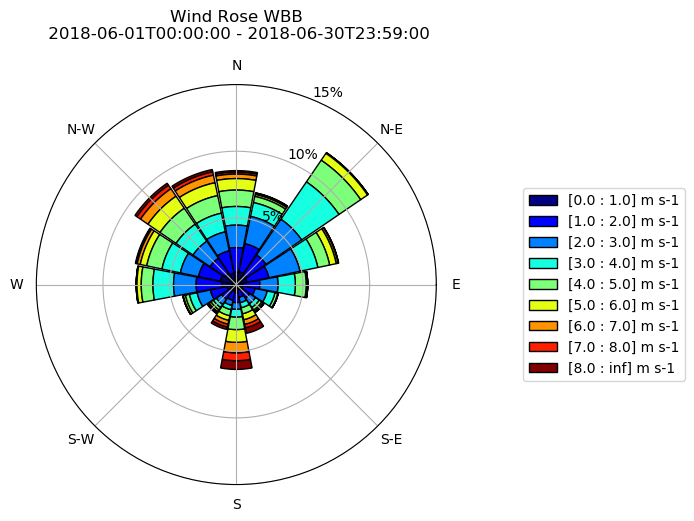

In [8]:
# use code created by Brian Blaylock that was adapted from other open source windrose code
using PyCall
pushfirst!(PyVector(pyimport("sys")["path"]), "")
@pyimport windrose as wr

#get first and last dates for label
firsttime = df.Date[1]
lasttime = df.Date[end]

fig = figure(figsize=(5, 10), facecolor="w", edgecolor="w")
rect = [0.1, 0.1, 0.8, 0.8]
#the critical part to get polar coordinate
ax = wr.WindroseAxes(fig, rect)
fig[:add_axes](ax)

#wind direction is "x" and wind speed is "y"
ax[:bar](winda[:, 2], winda[:, 1],
           bins=[0, 1, 2, 3, 4, 5, 6, 7, 8],
           nsector=16,
           normed=true,
           opening=.95,
           edgecolor="k")
#the above causes some warning diagnostics that I will ignore!
l = ax[:legend]()
setp(l[:get_texts]())
legend(loc="center left", bbox_to_anchor=(1.2, 0.5), prop=Dict("size"=>10))
title("Wind Rose WBB\n $firsttime - $lasttime\n")
grid(true)
yticks(collect(0:5:100))
ax[:set_yticklabels](["", "5%", "10%", "15%", "20%", "25%", "30%", "", "40%"])
ax[:set_rmax](15)
savefig("figure_2.14_julia.png")

# Resultant vs Mean Wind

In [9]:
#one of the nice features of DataFrames. group in this case by time of day
dfcp = copy(df)
dfcp.Date = hour.(df.Date)
diurnal_wind = hcat(colwise(mean, groupby(dfcp, :Date))...)

6×24 Array{Float64,2}:
   0.0         1.0        2.0       …  21.0      22.0      23.0     
   2.73341     2.69441    2.68791       3.70251   3.45455   3.21653 
 111.616     100.664     94.5386       91.3343   87.5101   98.0097  
   3.49943     3.49123    3.48103       4.63261   4.36461   4.03323 
  -1.60656    -1.43419   -1.53426      -2.08514  -2.14352  -1.99569 
  -0.204297   -0.759567  -0.773662  …  -1.93554  -1.4511   -0.723949

In [10]:
ds = diurnal_wind[2, :]
du = diurnal_wind[5, :]
dv = diurnal_wind[6, :]
#compute resultant wind speed for each hour
ressp = hypot.(du, dv)
display(ds)
display(ressp)

24-element Array{Float64,1}:
 2.733414358394569 
 2.6944059124502573
 2.6879080201906893
 2.241184888380079 
 2.484980281690137 
 2.263299319727892 
 1.939687131050768 
 1.5561762988908336
 1.4095534200113062
 2.0408073496659265
 2.710217028380633 
 3.1005113952195593
 3.5869340974212056
 3.9464437012263116
 4.169566666666668 
 4.389011111111107 
 4.19192777777777  
 4.257927777777779 
 3.9947192884936156
 3.5011957730812027
 3.276855555555553 
 3.702506948304603 
 3.454552031163044 
 3.21652808988764  

24-element Array{Float64,1}:
 1.6194932182076132
 1.622915122849759 
 1.7182835097845783
 1.166789421147268 
 1.274519387503345 
 1.129720317473175 
 0.9534423828776994
 0.5185960115656805
 0.335163817956545 
 0.9070266888420085
 1.3924965733875845
 1.4536232443102413
 1.7880441017073614
 1.7497381311766984
 2.0334889505572873
 2.0391530456649245
 2.075639243237464 
 2.3445739750066195
 2.056178741288326 
 1.803331756208533 
 1.7484729397548346
 2.8450133010689385
 2.588508258085842 
 2.1229417130173855

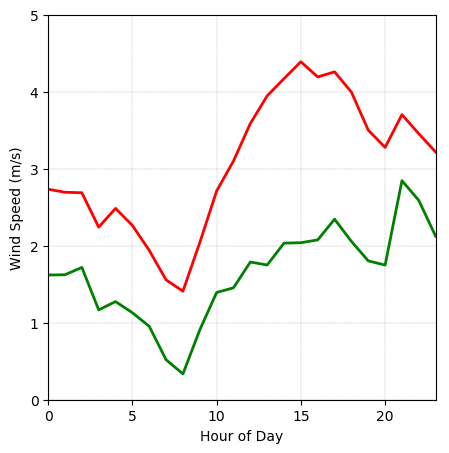

In [11]:
#plot mean wind speed vs resultant wind speed
fig15, ax = subplots(1, 1, figsize=(5, 5), facecolor="w", edgecolor="w")
xd = collect(0:23)
ax[:plot](xd, ds, color="red", linewidth=2)
ax[:plot](xd, ressp, color="green", linewidth=2)
ax[:set](xlim=(0, 23), ylim=(0, 5))
ax[:set](xlabel="Hour of Day", ylabel="Wind Speed (m/s)")
ax[:grid](linestyle="--", color="grey", linewidth=.2)
savefig("figure_2.15_2019_julia.png")

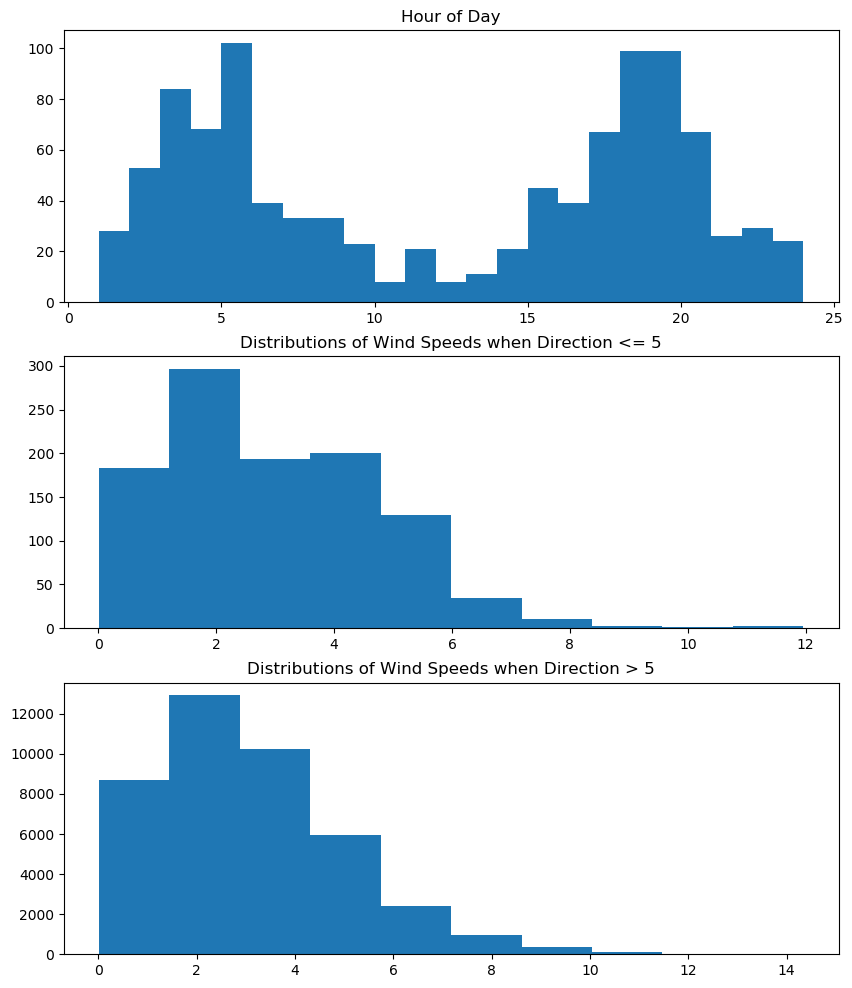

PyObject Text(0.5,1,'Distributions of Wind Speeds when Direction > 5')

In [12]:
# Showing that the large number of observations between 0 and 5 degrees probably isn't anomalous
# Most of these observations are at sunrise/sunset, and the wind speed distribution is not very different
figure(figsize=(10, 12))
subplot(311)
hist(hour.(df.Date[df.Direction .<= 5]), 1:24, align="mid")
title("Hour of Day")
subplot(312)
hist(df.Speed[df.Direction .<= 5])
title("Distributions of Wind Speeds when Direction <= 5")
subplot(313)
hist(df.Speed[df.Direction .> 5])
title("Distributions of Wind Speeds when Direction > 5")